# 1. Imports

In [1]:
#Imports - general
import random
random.seed(15)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper')
from math import sqrt
from sklearn.metrics import f1_score, roc_curve, auc, precision_score, accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline

#Imports - RDKit
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem.rdMolDescriptors import *

#Imports - additional
from os import listdir #for getting a list of files in a dir to process checkpoints
import time # for real-time timing the progress of the network

/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Some global variables

In [2]:
batch_number = 0
#Get the list of filenames in data/targets/
#ordered by the size of class, descending:
with open("receptors_desc.txt", "r") as f:
    receptors = [l.strip().split() for l in f.readlines()]
print(len(receptors))
receptors[:5]

73


[['DRD2.ism', '6229'],
 ['HTR1A.ism', '5592'],
 ['SLC6A4.ism', '5414'],
 ['OPRM1.ism', '5263'],
 ['ADORA1.ism', '4136']]

---

# 2. Functions

## Preparing the dataset

#### Reading smiles of molecules from .ism files

In [3]:
def read_ism(file_name):
    ''' Parse an .ism file, returning a list of smiles of molecules '''
    mol_list = []
    with open(file_name, 'r') as f:
        frl = f.readlines()
    for line in frl:
        line = line.split('\t')
        smile = line[0]
        mol_list.append(smile)
    return mol_list

#### Creating molecule representations

In [4]:
def get_class_vectors(mol_matrix, rType = 'fingerprint', f_size=2048):
    ''' For each molecule in the array (list of lists):
        create its representation for training (ingerprint/descriptor/mixed)
        and a binary vector showing which classes it belongs to.
        Fingerprint will be of size = f_size.
    '''
    cv_dict = {}
    for i,l in enumerate(mol_matrix):
        for smile in l:
            if smile not in cv_dict:
                
                mol = MolFromSmiles(smile)
                if rType == 'fingerprint':
                    rep = fingerprint(mol, f_size)
                elif rType == 'descriptor':
                    rep = descriptor(mol)
                else:
                    rep = descriptor(mol) + list(fingerprint(mol, f_size))
                
                labels = [0]*len(mol_matrix)
                cv_dict[smile] = [rep, labels]
            cv_dict[smile][1][i] = 1
    # Normalize descriptors
    if rType != 'fingerprint':
        matrix_to_norm = []
        for vals in cv_dict.values():
            matrix_to_norm.append(vals[0][:37]) #there are 37 descriptors
        matrix_to_norm = np.array(matrix_to_norm)
        v_min = matrix_to_norm.min(axis=0)
        v_max = matrix_to_norm.max(axis=0) - v_min
        for key in cv_dict.keys():
            for i in range(37):
                normed_val = (cv_dict[key][0][i] - v_min[i]) / v_max[i]
                cv_dict[key][0][i] = normed_val
    return cv_dict

def fingerprint(mol, f_size=2048):
    return GetMorganFingerprintAsBitVect(mol,2,f_size)

def descriptor(mol):
    functions = [CalcChi0n,
            CalcChi0v,
            CalcChi1n,
            CalcChi1v,
            CalcChi2n,
            CalcChi2v,
            CalcChi3n,
            CalcChi3v,
            CalcChi4n,
            CalcChi4v,
            CalcExactMolWt,
            CalcFractionCSP3,
            CalcHallKierAlpha,
            CalcKappa1,
            CalcKappa2,
            CalcKappa3,
            CalcLabuteASA,
            CalcNumAliphaticCarbocycles,
            CalcNumAliphaticHeterocycles,
            CalcNumAliphaticRings,
            CalcNumAmideBonds,
            CalcNumAromaticCarbocycles,
            CalcNumAromaticHeterocycles,
            CalcNumAromaticRings,
            CalcNumBridgeheadAtoms,
            CalcNumHBA,
            CalcNumHBD,
            CalcNumHeteroatoms,
            CalcNumHeterocycles,
            CalcNumLipinskiHBA,
            CalcNumLipinskiHBD,
            CalcNumRings,
            CalcNumSaturatedCarbocycles,
            CalcNumSaturatedHeterocycles,
            CalcNumSaturatedRings,
            CalcNumSpiroAtoms,
            CalcTPSA]
        
    descriptors = []
    for function in functions:
        descriptors.append(function(mol))
    return descriptors

#### Creating training and validation sets

In [5]:
def prepare_sets(mol_matrix, val_prc=0.2, rType='fingerprint', f_size=2048):
    ''' Create training and validation sets with labels from an array of smiles
        rType - type of representation - fingerprint/descriptor/mixed
        f_size - size of the fingerprint if rType is fingerprint or mixed '''
    # Create a representation and a class vector for each molecule
    molecules = get_class_vectors(mol_matrix,rType,f_size)

    # Split the data into training and validation sets
    mts=[[],[]]
    for val in molecules.values():
        mts[0].append(val[0]) # [fingerprint]
        mts[1].append(val[1]) # [label]

    molecules_split = train_test_split(mts[0], mts[1], test_size=val_prc, random_state=15)#, stratify=mts[1])

    # Validation set:
    #     a list of representations (mols) and
    #     a list of corresponding class vectors (labels)
    val_mols = np.array(molecules_split[1])
    val_labels = np.array(molecules_split[3])
    # Training set:
    train_set = [[],[]]
    train_set[0] = np.array(molecules_split[0])
    train_set[1] = np.array(molecules_split[2])
    
    return train_set, val_mols, val_labels

## Neuron layers

In [6]:
def neuron_layer(isize, hsize, prev_layer):
    ''' Create a single neuron layer - weight, bias, placeholder '''
    # weights and biases
    w = tf.Variable(tf.random_normal((isize, hsize), stddev=1/sqrt(isize)))
    b = tf.Variable(tf.random_normal((hsize,), stddev=0.1))
    # neuron
    h = tf.nn.relu(tf.matmul(prev_layer, w) + b)
    return w,b,h

def setup_layers(layers, osize, isize=2048):
    ''' Create placeholders, weights and biases for all requested layers '''
    x = tf.placeholder(tf.float32, shape=[None,isize])
    active_layers = {'x':x,'w':[],'b':[],'h':[]}
    
    for i in range(len(layers)):
        if i == 0:
            w,b,h = neuron_layer(isize, layers[0], x)
        else:
            w,b,h = neuron_layer(layers[i-1], layers[i], prev_h)
        active_layers['w'].append(w)
        active_layers['b'].append(b)
        active_layers['h'].append(h)
        prev_h = h
    
    # Output Layer
    wo = tf.Variable(tf.random_normal((layers[-1], osize), stddev=1/sqrt(layers[-1])))
    bo = tf.Variable(tf.random_normal((osize,), stddev=0.1))
    a = tf.matmul(h, wo) + bo #h is the one last initialized in the loop > of the last layer
    
    # Placeholder for targets
    t = tf.placeholder(tf.float32, shape=[None, osize])
    
    active_layers['out'] = [wo,bo,a,t]
    return active_layers

## Training functions

In [7]:
def next_batch(data, size): #data = [[fingerprints], [labels]]
    ''' Extract the next batch from a dataset.
        If dataset size is not dividable by batch size with reminder 0,
       the last full batch and the remaining incomplete batch will be merged 
       to incorporate all data.'''
    global batch_number
    if batch_number == len(data[0])//size-1:
        #the last batch may be larger to incorporate all data
        # -1 because the first batch number is 0
        start = batch_number*size
        batch_number = 0
        return data[0][start:], data[1][start:]
    start = batch_number*size
    batch_number += 1
    return data[0][start:start+size], data[1][start:start+size]

def shuffle_data(data):
    '''Used to shuffle the training set after an epoch'''
    indices = list(range(len(data[0])))
    random.shuffle(indices)
    new_data = [data[0][indices], data[1][indices]]
    return new_data

def timer(start,end):
    ''' For timing the training of the network '''
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return "{:0>2}:{:0>2}:{:0>2}".format(int(hours),int(minutes),int(seconds))

def tf_fractions(a1, a2):
    ''' Calculate true/false positives/negatives in a2 based on a1
        for each class seperately. '''
    num_class = len(a1[0]) #number of classes
    tp = np.array([0] * num_class)
    fn = np.array([0] * num_class)
    tn = np.array([0] * num_class)
    fp = np.array([0] * num_class)
    for i in range(num_class):
        for j in range(len(a1)):
            if a2[j][i] == a1[j][i]:
                if a1[j][i] == 1:
                    tp[i] += 1
                else:
                    tn[i] += 1
            else:
                if a1[j][i] == 1:
                    fn[i] += 1
                else:
                    fp[i] += 1
    return [tp,fn,tn,fp]

In [8]:
def train_network(data, batch_size, epochs, verbose=True, save=True):
    ''' This function trains the network, returning the rate of training and validation accuracy '''
    # Variables:
    global start, train, val_pred, batch_number
    iterations = len(data[0]) // batch_size * epochs
    if verbose: print(iterations, ' iterations')
    tr_rate = []
    val_rate = []
    f1 = [[],[],[]]
    tf_frac = []
    batch_number = 0
    save_step=0
    # Training:
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())

        if save:
            saver.save(session, "tmp/checkpoint", global_step=save_step)
        
        # Train the network
        for i in range(iterations):
            if i != 0 and batch_number == 0:
                data = shuffle_data(data)
            
            mols, labels = next_batch(data, batch_size)
            
            session.run(train, feed_dict={x: mols, t: labels})
            
            # Display progress and make a checkpoint
            if i == 0 or (i+1)%(iterations//10) == 0:
                if save:
                    save_step += 1
                    saver.save(session, "tmp/checkpoint", global_step = save_step)
                if verbose:
                    progress = int((i+1)/(iterations//10))*10
                    now = timer(start,time.time())
                    print("%3i" % progress + '%, ' + str(now))                
            
            # Validate predictions
            if i % 200 == 0 or i == iterations-1:
                
                tr_target = labels
                tr_predictions = session.run(predict, feed_dict={x: mols, t: labels})
                tr_rate.append((tr_target == tr_predictions).all(axis=1).mean())

                val_predictions = session.run(predict, feed_dict={x: val_mols, t: val_labels})
                val_rate.append((val_labels == val_predictions).all(axis=1).mean())
                
                
                f1[0].append(f1_score(val_labels, val_predictions, average='micro'))
                f1[1].append(f1_score(val_labels, val_predictions, average='macro'))
                f1[2].append(f1_score(val_labels, val_predictions, average='weighted'))
                
        tf_frac = tf_fractions(val_labels,val_predictions)
        # Final checkpoint
        if save:
            saver.save(session, "tmp/checkpoint", global_step=save_step+1)
    return tr_rate, val_rate, f1, tf_frac


## Functions to draw and save plots

In [9]:
def filename_gen(plot_type='', path=''):
    ''' Generate filename for a plot. '''
    if plot_type != '':
        plot_type += '_'
    filename = plot_type
    layers_str = "{}'{}".format(len(layers),max(layers))
    filename += "{}_{}_{}_{:>6}_{}_{}_{:.4}_{}".format(
                num_class, f_size, layers_str, learning_rate, batch_size, epochs, max(val_rate), rType)
    filename = filename.replace(".","'")
    filename = filename.replace(" ","_")
    filename = path + filename + ".pdf"
    return filename

def save_accuracy_plot(tr_rate, save=True, path="plots/"):
    ''' Draws and saves a plot which displays changes of accuracy 
        during training for training and validation sets. '''
    plt.close()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    x = [i*200 for i in range(len(tr_rate))]
    ax.plot(x,tr_rate, label='trening')
    ax.plot(x,val_rate, label='walidacja')
    ax.legend(loc=5)
    ax.set_ylabel('Dokładność')
    ax.set_xlabel('Krok')
    plt.ylim([0,1])
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
    
    title = "Cele terapeutyczne: {:2}, Szybkość uczenia: {}\nWarstwy: {}, Rozmiar batcha: {}, Liczba epok: {}".format(
        num_class, learning_rate, layers, batch_size, epochs)
    plt.title(title);
    
    if save:
        filename = filename_gen('',path)
        plt.savefig(filename);

def save_f1_plot(f1, save=True, path="plots/"):
    ''' Draws and saves a plot which displays changes of F1-score
        during training for the validation set.
        F1 calculated and drawn in three types of averaging. '''
    plt.close()
    fig = plt.figure()
    x = [i*200 for i in range(len(f1[0]))]
    ax = fig.add_subplot(111)
    
    ax.plot(x,f1[0], label='F1 micro')
    ax.plot(x,f1[1], label='F1 macro')
    ax.plot(x,f1[2], label='F1 ważone')
    ax.legend(loc=7)
    ax.set_ylabel('F1')
    ax.set_xlabel('Krok')
    plt.ylim([0,1])
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
    
    title = "Cele terapeutyczne: {:2}, Szybkość uczenia: {}\nWarstwy: {}, Rozmiar batcha: {}, Liczba epok: {}".format(
        num_class, learning_rate, layers, batch_size, epochs)
    plt.title(title);
    
    if save:
        filename = filename_gen('f1',path)
        plt.savefig(filename);

def save_tf_fractions_plot(tff, save=True, path='plots/'):
    ''' Draws and saves a histogram of true/false positive/negative fractions:
        True Positive rate, False Positive Rate, False Negative Rate and
        False Discovery Rate.
        True Negative Rate not included due to having values indistinguishably
        close to 100%; however, TNR = 100% - FPR, and the FPR histogram is more
        visually clear. '''
    plt.close()
    fig = plt.figure()
    subplots = [fig.add_subplot(221), fig.add_subplot(222),
                fig.add_subplot(223), fig.add_subplot(224)]
    titles = ['Odsetek prawdziwie pozytywnych', 'Odsetek fałszywie pozytywnych',
              'Odsetek fałszywie negatywnych', 'Odsetek fałszywych odkryć']
    rate_values = [tff[0]/(tff[0]+tff[1]), tff[3]/(tff[2]+tff[3]),
                   tff[1]/(tff[0]+tff[1]), tff[3]/(tff[0]+tff[3])]
    xlabel = 'Cele terapeutyczne'
    xrange = range(1,len(tff[0])+1)
    
    for i, ax in enumerate(subplots):
        ax.bar(xrange, rate_values[i])
        ax.set_title(titles[i])
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_xlim([0,num_class+2])
        vals = ax.get_yticks()
        if i == 1: #false positive rate is very small
            ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
        else:
            ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
    
    plt.tight_layout()
    title = "Cele terapeutyczne: {:2}, Szybkość uczenia: {}\nWarstwy: {}, Rozmiar batcha: {}, Liczba epok: {}".format(
        num_class, learning_rate, layers, batch_size, epochs)
    fig.suptitle(title)
    fig.subplots_adjust(top=0.85)
    
    if save:
        filename = filename_gen('tff',path)
        plt.savefig(filename)

---

# 3. Script

### Prepare data

In [10]:
num_class = 73 #first n most numerous classes - 2<=n<=73
ism_path = 'data/targets/'   #path to .ism files which represent classes and contain molecules
mol_matrix = []
for line in receptors[:num_class]:
    name = line[0]
    mol_list = read_ism(ism_path + name)
    mol_matrix.append(mol_list)
mol_matrix[0][:3]

['CN1CCN(CC1)C2=Cc3ccccc3C(=C(C)C)c4ccccc24',
 'CN1CCN(CC1)C2=Nc3cc(Cl)ccc3Nc4ccccc24',
 'CN1CCC(CC1)C2=Cc3cc(Cl)ccc3Cc4ccccc24']

# TESTING - splitting data

In [76]:
data = get_class_vectors(mol_matrix,"fingerprint",1024)
smiles, labels = [], []
for key, val in data.items():
    smiles.append(key)    #  smile       #CHANGE TO "fingerprints" WHEN IMPLEMENTING
    labels.append(val[1]) # [label]
# ADD THE FOLLOWING WHEN IMPLEMENTING
#fingerprints = np.array(fingerprints)
#labels = np.array(labels)

In [23]:
# Split the data into training and validation sets
data_split = train_test_split(smiles, labels, test_size=0.2, random_state=15)#, stratify=labels)

In [24]:
# Are there any repetitions between the train and validation sets?
train_smiles, test_smiles = data_split[0], data_split[1]
repeated=[]
for smile in train_smiles:
    if smile in test_smiles:
        repeated.append(smile)
len(repeated)

### Unique labels

In [87]:
# All labels
np_labels = np.array(mts[1])
np_labels.shape

(82957, 73)

In [75]:
# Unique labels
unique_labels, unique_indices, unique_counts = np.unique(ar=np_labels, return_index=True, return_counts=True, axis=0)
unique_labels.shape

(997, 73)

In [74]:
# The labels that appear only once
unique_labels[unique_counts==1].shape

(506, 73)

In [70]:
# Percentage of singular labels in relation to all molecules
all_singular = np.sum(unique_labels[unique_counts==1], axis=0)
all_singular/sum(np_labels)*100

array([ 3.11496468,  3.05793991,  2.49353528,  0.68402052,  0.1450677 ,
        0.86676573,  0.47967685,  0.0533049 ,  2.03455964,  0.3353829 ,
        0.11719895,  4.16010085,  7.02087287,  2.42275281,  6.62275887,
        0.27667984,  7.12855427,  0.20333469,  0.21626298,  0.27855153,
        0.40650407,  5.79862941,  0.        ,  0.05333333,  0.50139276,
        8.92359175,  0.05592841,  4.60674157,  4.49640288,  5.75016523,
        0.69979006,  0.6378455 ,  4.4935806 ,  9.84902948,  0.22156573,
        1.27915726,  0.99616858,  1.92307692, 11.4924182 ,  0.32894737,
       11.45228216,  0.43668122,  0.61188811, 10.9800363 ,  0.0929368 ,
        3.93852065,  9.1350826 ,  2.64900662,  0.25      ,  1.40664962,
        0.1303781 ,  0.40106952,  0.13793103,  0.29761905,  0.9478673 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        3.003003  ,  0.        ,  0.33444816, 12.23628692,  0.51282051,
        1.57068063,  0.        ,  0.56497175,  0.        ,  0.  

### Separate singular labels from the dataset

In [98]:
np_smiles = np.array(smiles)

In [91]:
singular_indices = unique_indices[unique_counts==1]

In [100]:
labels_no_singular = np.delete(np_labels, singular_indices, axis=0)

In [101]:
labels_only_singular = np_labels[singular_indices]

In [99]:
smiles_no_singular = np.delete(np_smiles, singular_indices, axis=0)
smiles_only_singular = np_smiles[singular_indices]

In [116]:
# Split the data into training and validation sets
data_split = train_test_split(smiles_no_singular, 
                              labels_no_singular, test_size=0.2, random_state=15, stratify=labels_no_singular)

In [117]:
sum(data_split[3])/sum(data_split[2])

array([0.24798345, 0.2487906 , 0.2500592 , 0.24988044, 0.25037844,
       0.2505467 , 0.24944532, 0.25      , 0.24955563, 0.24991237,
       0.25009168, 0.24682247, 0.24418113, 0.25011246, 0.24731183,
       0.24962853, 0.24878837, 0.24949084, 0.24972914, 0.25029104,
       0.24920331, 0.24790503, 0.25      , 0.25016678, 0.25070028,
       0.24942617, 0.25052484, 0.25221239, 0.25235849, 0.24868651,
       0.25132275, 0.24955437, 0.24906716, 0.24652087, 0.25092593,
       0.25071497, 0.25072604, 0.25      , 0.24606742, 0.24819773,
       0.25087925, 0.25      , 0.25082508, 0.24492386, 0.25      ,
       0.24688279, 0.25      , 0.24929178, 0.2507837 , 0.24757282,
       0.24959217, 0.25      , 0.25043178, 0.25      , 0.24900398,
       0.25098814, 0.24285714, 0.25073746, 0.24846626, 0.2527881 ,
       0.24710425, 0.25      , 0.25210084, 0.25301205, 0.24358974,
       0.25333333, 0.25827815, 0.23943662, 0.24626866, 0.25882353,
       0.25      , 0.25      , 0.23404255])

In [118]:
# Split the data into training and validation sets
singular_split = train_test_split(smiles_only_singular, 
                              labels_only_singular, test_size=0.2, random_state=15)#, stratify=labels_no_singular)

In [124]:
sum(singular_split[3])/sum(singular_split[2])

/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.25974026, 0.24817518, 0.21621622, 0.24137931, 0.        ,
       0.34615385, 0.1875    , 1.        , 0.25862069, 0.09090909,
       0.        , 0.26923077, 0.24719101, 0.25454545, 0.26573427,
       0.4       , 0.21088435, 0.        , 0.        , 0.2       ,
       0.33333333, 0.26436782,        nan, 0.        , 0.28571429,
       0.26984127, 0.        , 0.32258065, 0.31578947, 0.26086957,
       0.25      , 0.28571429, 0.36956522, 0.21238938, 2.        ,
       0.54545455, 0.3       , 0.38888889, 0.26315789, 1.        ,
       0.26605505, 0.66666667, 0.16666667, 0.24742268, 0.        ,
       0.28125   , 0.18987342, 0.5       , 0.        , 1.2       ,
       0.        , 0.        , 0.        , 1.        , 0.2       ,
              nan,        nan,        nan,        nan,        nan,
       0.25      ,        nan, 0.        , 0.26086957, 0.        ,
       0.5       ,        nan, 0.        ,        nan,        nan,
              nan,        inf, 0.        ])

---

## Proposed verison of    prepare_sets()

In [137]:
def separate_singular_uniques(fingerprints, labels):
    '''
    Separate examples with unique labels which appear only once.
    This is done to ensure proper functionality of *train_test_split()*
    when using the *stratify* argument.
    '''
    # Find indices of singular uniques
    unique_labels, unique_indices, unique_counts = np.unique(
        ar=labels, return_index=True, return_counts=True, axis=0)
    singular_indices = unique_indices[unique_counts==1]
    # Separate fingerprints
    fingerprints_no_singular = np.delete(fingerprints, singular_indices, axis=0)
    fingerprints_only_singular = fingerprints[singular_indices]
    # Separate labels
    labels_no_singular = np.delete(labels, singular_indices, axis=0)
    labels_only_singular = labels[singular_indices]
    
    return fingerprints_no_singular, labels_no_singular, fingerprints_only_singular, labels_only_singular

In [135]:
fns,lns,fos,los = separate_singular_uniques(np_smiles,np_labels)

In [136]:
def prepare_sets(mol_matrix, val_prc=0.2, rType='fingerprint', f_size=2048):
    ''' Create training and validation sets with labels from an array of smiles
        rType - type of representation - fingerprint/descriptor/mixed
        f_size - size of the fingerprint if rType is fingerprint or mixed '''
    # Create a representation and a class vector for each molecule
    molecules = get_class_vectors(mol_matrix,rType,f_size)

    # Split the data into training and validation sets
    fingerprints, labels = [],[]
    for val in molecules.values():
        fingerprints.append(val[0]) # [fingerprint]
        labels.append(val[1]) # [label]
    fingerprints = np.array(fingerprints)
    labels = np.array(labels)
    
    fns,lns,fos,los = separate_singular_uniques(np_smiles,np_labels)

    no_singular = train_test_split(fns, lns, test_size=val_prc, random_state=15, stratify=lns)
    only_singular = train_test_split(fns, lns, test_size=val_prc, random_state=15)
    
    # Training set:
    #     a list of representations (mols) and
    #     a list of corresponding class vectors (labels)
    train_mols = np.append(no_singular[0], only_singular[0])
    train_labels = np.append(no_singular[2], only_singular[2])
    # Validation set:
    #     a list of representations (mols) and
    #     a list of corresponding class vectors (labels)
    val_mols = np.append(no_singular[1], only_singular[1])
    val_labels = np.append(no_singular[3], only_singular[3])
    
    train_set = [train_mols, train_labels] # CONSIDER SPLITTING THIS!!!
                                           # otherwise: Training set is pakcaged in a list for ease of use later on.
    return train_set, val_mols, val_labels

In [138]:
%%time
all_data = prepare_sets(mol_matrix, f_size=1024)

CPU times: user 2min 58s, sys: 1.78 s, total: 3min
Wall time: 2min 57s


### Type of representation:

In [11]:
rType = 'fingerprint'
f_size = 1024        #size of fingerprint, if rType = 'fingerprint' or 'mixed'
%time train_set,val_mols,val_labels = prepare_sets(mol_matrix, 0.2, rType, f_size)

CPU times: user 2min 53s, sys: 176 ms, total: 2min 53s
Wall time: 2min 53s


### Saving and loading prepared sets

In [14]:
import pickle

def load_var(name):
    with open(name,'rb') as f:
        return pickle.load(f)

def save_var(name,var):
    with open(name,'wb') as f:
        pickle.dump(var,f)

In [15]:
save_var("1024_n_1.txt",{"ts":train_set,"vm":val_mols,"vl":val_labels})

In [12]:
loaded = load_var("1024_.txt")
train_set=loaded["ts"]
val_mols=loaded["vm"]
val_labels=loaded["vl"]

###  User-defined network variables:

In [12]:
layers = [500,500]
learning_rate = 0.001
batch_size = 25
epochs = 10

### Create and train the network

In [13]:
tf.reset_default_graph()
tf.set_random_seed(15)
random.seed(15)
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
start = time.time()

#Automatic network variables.
isize = len(val_mols[0])
osize = num_class
'''
isize - size of the input layer, equal to the size 
        of the data representation (fingerprint/descriptor)
osize - size of the output layer, equal to the number of classes.
'''

# Neuron layers
active_layers = setup_layers(layers, osize, isize)
x = active_layers['x'] # first placeholder
a = active_layers['out'][2] # output layer activations
t = active_layers['out'][3] # placeholder for targets

saver = tf.train.Saver(max_to_keep=12)

# Objective
'''Adam Optimizer'''
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=t, logits=a))
train = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

# Prediction
y = tf.nn.sigmoid(a)
predict = tf.round(y)

# Train the network
tr_rate, val_rate, f1, tf_frac = train_network(train_set, batch_size, epochs, save=True, verbose=True)
full_time = timer(start,time.time())
full_time

2018-09-27 15:00:10
26540  iterations
  0%, 00:00:01


/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 10%, 00:00:11
 20%, 00:00:21
 30%, 00:00:31
 40%, 00:00:41
 50%, 00:00:51
 60%, 00:01:00
 70%, 00:01:10
 80%, 00:01:20
 90%, 00:01:30
100%, 00:01:40


'00:01:44'

### Accuracy

In [14]:
max(val_rate)*100

76.0788331726133

# 4. Plots for evaluating predictions, and saving results.

### Accuracy - training and validation rates

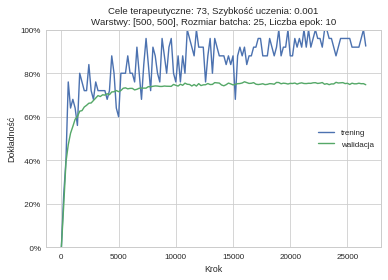

In [15]:
save_accuracy_plot(tr_rate, save=False, path='plots/')

### F1 score

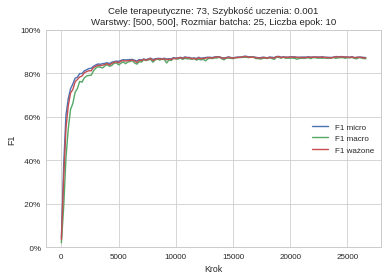

In [16]:
save_f1_plot(f1, save=False, path='plots/')

### True/false-positive/negative-related histograms

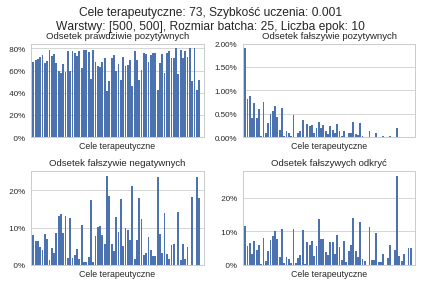

In [17]:
save_tf_fractions_plot(tf_frac, save=False, path='plots/')

### Saving results to file

In [ ]:
# Create a new file
with open('plots/desc/desc.csv','w') as f:
    f.write('Type of Representation,Number of classes,Fingerprint size,Hidden Layers,Learning Rate,Batch Size,Number of Epochs, Max. Validation Rate\n')

In [ ]:
def save_res_to_file(rType,num_class,f_size,layers,learning_rate,batch_size,epochs,max_val):
    with open('plots/desc/desc.csv','a') as f:
        layers_str = str(layers).replace(',',';') #for .csv compatibility reasons
        s = "{},{},{},{},{},{},{},{:.4}\n".format(
            rType,num_class,f_size,layers_str,learning_rate,batch_size,epochs,max_val)
        f.write(s)

---

# 5. Testing the network on drugs

## Preparing the test set

In [18]:
with open('data/drug_targets_untrained.csv') as f: #or 'data/drug_targets.csv' for the full set
    drug_targets = [l.strip().split(',') for l in f.readlines()[1:]]
class_to_smiles = {}
for l in drug_targets:
    if l[2] not in class_to_smiles.keys():
        class_to_smiles[l[2]] = []
    class_to_smiles[l[2]].append(l[4])

targets = [l[0].strip('.ism') for l in receptors]

drug_mol_matrix = [[]]*73
for k, v in class_to_smiles.items():
    drug_mol_matrix[targets.index(k)] = v

cv_dict = get_class_vectors(drug_mol_matrix, f_size=f_size)
drug_mols, drug_labels = [], []
for v in cv_dict.values():
    drug_mols.append(v[0])
    drug_labels.append(v[1])
drug_mols, drug_labels = np.array(drug_mols), np.array(drug_labels)

## *Rebuilding the network
(if the training code in section 3. has not been run)

In [20]:
tf.reset_default_graph()
tf.set_random_seed(15)
random.seed(15)
# Automatic network variables
isize = 4096
osize = 73
active_layers = setup_layers([800,800], osize, isize)
x = active_layers['x'] # first placeholder
a = active_layers['out'][2] # output layer activations
t = active_layers['out'][3] # placeholder for targets
saver = tf.train.Saver(max_to_keep=12)
# Objective
'''Adam Optimizer'''
cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(a, t))
train = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)
# Prediction
y = tf.nn.sigmoid(a)
predict = tf.round(y)

## Restoring network from checkpoint and running test data

In [19]:
f1=[[],[],[]]
with tf.Session() as sess:
    saver.restore(sess, 'checkpoint-12')
    
    drug_pred = sess.run(predict, feed_dict={x: drug_mols, t: drug_labels}) #rounded prediction values
    drug_pred_roc = sess.run(y, feed_dict={x: drug_mols, t: drug_labels}) #not-rounded, raw prediction values
    drug_rate = (drug_labels == drug_pred).mean(axis=0)
    
    f1[0].append(f1_score(drug_labels, drug_pred, average='micro'))
    f1[1].append(f1_score(drug_labels, drug_pred, average='macro'))
    f1[2].append(f1_score(drug_labels, drug_pred, average='weighted'))
    score_per_class = tf_frac(drug_labels,drug_pred)

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for checkpoint-12
	 [[Node: save/RestoreV2_2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_2/tensor_names, save/RestoreV2_2/shape_and_slices)]]
	 [[Node: save/RestoreV2_4/_3 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_10_save/RestoreV2_4", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'save/RestoreV2_2', defined at:
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-7a5616769527>", line 22, in <module>
    saver = tf.train.Saver(max_to_keep=12)
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1040, in __init__
    self.build()
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1070, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 675, in build
    restore_sequentially, reshape)
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 402, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 242, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 668, in restore_v2
    dtypes=dtypes, name=name)
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/maks/anaconda3/envs/qSAR/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to find any matching files for checkpoint-12
	 [[Node: save/RestoreV2_2 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_2/tensor_names, save/RestoreV2_2/shape_and_slices)]]
	 [[Node: save/RestoreV2_4/_3 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_10_save/RestoreV2_4", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


In [ ]:
precision_score(drug_pred,drug_labels, average="weighted")
precision_score((drug_pred_roc > 0.01).astype(float),drug_labels, average="weighted")
tf_fractions(drug_labels, drug_pred)
[sum(i) for i in tf_frac]
fpr, tpr, thresholds = roc_curve(drug_labels.flatten(), drug_pred_roc.flatten())
auc(fpr,tpr)

In [ ]:
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='Krzywa ROC (pole powierzchni = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='#4C72B0', lw=2, linestyle='--')
plt.axes().set_aspect('equal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Odsetek fałszywie pozytywnych')
plt.ylabel('Odsetek prawdziwie pozytywnych')
plt.title('Charakterystyka operacyjna odbiornika (ROC curve)')
plt.legend(loc="lower right")
#plt.savefig('plots/best/drugs_roc.pdf')
plt.show()

---